# Load the Module

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Processing

In [ ]:
# Directories
train_dir = r"C:\\Users\\sabof\\OneDrive - Université de Lausanne\\Bureau\\UNIL_CEE\\Semester 3\\Machine learning\\processed\\train"
val_dir = r"C:\\Users\\sabof\\OneDrive - Université de Lausanne\\Bureau\\UNIL_CEE\\Semester 3\\Machine learning\\processed\\val"
test_dir = r"C:\\Users\\sabof\\OneDrive - Université de Lausanne\\Bureau\\UNIL_CEE\\Semester 3\\Machine learning\\processed\\test"

# Hyperparameters
batch_size = 32
img_size = (224, 224)
num_classes = len(os.listdir(train_dir))

# Data Generators
datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen_val = ImageDataGenerator(rescale=1.0/255.0)
datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_generator = datagen_val.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
test_generator = datagen_test.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Load the Model and Training

In [ ]:
# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
checkpoint = ModelCheckpoint('mobilenetv2_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stopping]
)

# Evaluation time

In [ ]:
# Plot training and validation metrics
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on the test set
test_metrics = model.evaluate(test_generator, verbose=0)
test_loss = test_metrics[0]  # Loss is always the first value
test_accuracy = test_metrics[1]  # Accuracy is typically the second value
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# Predictions and Confusion Matrix for Test Set
test_preds = np.argmax(model.predict(test_generator, verbose=0), axis=1)
test_labels = test_generator.classes

# Compute Overall Precision and Recall
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

conf_matrix = confusion_matrix(test_labels, test_preds)


# Heatmap for Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# ROC AUC Curve for Test Set
test_probs = model.predict(test_generator, verbose=0)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

fpr, tpr, _ = roc_curve(test_labels_onehot.ravel(), test_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Test ROC AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# XIA visualization 

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load some test samples
test_data, test_labels = next(test_generator)  # Load a batch of test images

num_images = 4  # Number of images to visualize
fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))  # Create a grid layout

for i in range(num_images):
    sample_image = tf.convert_to_tensor(test_data[i:i+1], dtype=tf.float32)  # Convert to tensor

    # Get the gradients of the loss with respect to the input image
    with tf.GradientTape() as tape:
        tape.watch(sample_image)
        prediction = model(sample_image)  # Forward pass
        loss = tf.reduce_max(prediction)  # Use the maximum predicted class score as the loss

    gradients = tape.gradient(loss, sample_image)

    # Take the maximum along the color channels
    saliency = np.max(np.abs(gradients), axis=-1)[0]

    # Normalize the saliency map to be in the range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)

    # Resize and apply a colormap to the saliency map
    saliency_resized = cv2.resize(saliency, (sample_image.shape[2], sample_image.shape[1]))
    saliency_colored = cv2.applyColorMap((saliency_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    original_image = (test_data[i] * 255).astype(np.uint8)  # Scale back to original intensity
    superimposed_image = cv2.addWeighted(original_image, 0.6, saliency_colored, 0.4, 0)

    # Plot the images in the respective columns
    axes[i, 0].imshow(original_image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Original Image {i+1}')

    axes[i, 1].imshow(saliency, cmap='hot')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Saliency Map {i+1}')

    axes[i, 2].imshow(superimposed_image)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Superimposed Image {i+1}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


### Prediction on the common dataset

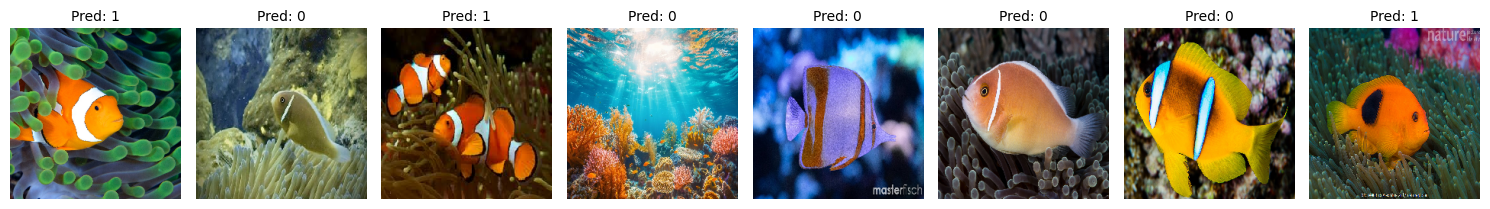

In [6]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the special set of images
special_set_dir = r"C:\Users\sabof\OneDrive - Université de Lausanne\Bureau\try_detect"

# List all images in the directory
image_paths = [os.path.join(special_set_dir, fname) for fname in os.listdir(special_set_dir) if fname.lower().endswith(('png', 'jpg', 'jpeg'))]

# Prepare figure for plotting
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))  # Single row for images

if len(image_paths) == 1:
    axes = [axes]  # Ensure axes is iterable for a single image

for idx, image_path in enumerate(image_paths):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    sample_image = img_to_array(img) / 255.0
    sample_image_tensor = tf.convert_to_tensor(sample_image[None, ...], dtype=tf.float32)  # Add batch dimension

    # Get the prediction
    prediction = model(sample_image_tensor)
    predicted_label = np.argmax(prediction[0])

    # Display the original image with predicted label
    original_image = (sample_image * 255).astype(np.uint8)

    axes[idx].imshow(original_image)
    axes[idx].axis('off')
    axes[idx].set_title(f'Pred: {predicted_label}', fontsize=10)

plt.tight_layout()
plt.show()



## Saliency map on the common dataset

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the special set of images
special_set_dir = r"C:\Users\sabof\OneDrive - Université de Lausanne\Bureau\try_detect"

# List all images in the directory
image_paths = [os.path.join(special_set_dir, fname) for fname in os.listdir(special_set_dir) if fname.lower().endswith(('png', 'jpg', 'jpeg'))]

# Prepare figure for plotting
fig, axes = plt.subplots(len(image_paths), 3, figsize=(15, len(image_paths) * 5))

for idx, image_path in enumerate(image_paths):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    sample_image = img_to_array(img) / 255.0
    sample_image_tensor = tf.convert_to_tensor(sample_image[None, ...], dtype=tf.float32)  # Add batch dimension

    # Get the gradients of the loss with respect to the input image
    with tf.GradientTape() as tape:
        tape.watch(sample_image_tensor)
        prediction = model(sample_image_tensor)  # Recompute prediction within the tape
        loss = tf.reduce_max(prediction)  # Use the predicted score for the top class

    gradients = tape.gradient(loss, sample_image_tensor)

    # Check if gradients are valid
    if gradients is None:
        print(f"Gradients are None for image {os.path.basename(image_path)}. Skipping...")
        continue

    # Take the maximum along the color channels
    saliency = np.max(np.abs(gradients), axis=-1)[0]

    # Normalize the saliency map to be in the range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)

    # Enhance brightness of the saliency map
    saliency = np.clip(saliency * 1.5, 0, 1)  # Scale values for increased brightness

    # Create a superimposed image by blending the saliency map with the original image
    saliency_resized = cv2.resize(saliency, (sample_image.shape[1], sample_image.shape[0]))
    saliency_colored = cv2.applyColorMap((saliency_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    original_image = (sample_image * 255).astype(np.uint8)  # Ensure correct scaling and data type
    superimposed_image = cv2.addWeighted(original_image, 0.6, saliency_colored, 0.4, 0)

    # Plot the original image, saliency map, and superimposed image
    axes[idx, 0].imshow(original_image)
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f'Original Image\nPred: {np.argmax(prediction[0])}', fontsize=10)

    axes[idx, 1].imshow(saliency, cmap='hot')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title('Saliency Map')

    axes[idx, 2].imshow(superimposed_image)
    axes[idx, 2].axis('off')
    axes[idx, 2].set_title('Superimposed Image')

plt.tight_layout()
plt.show()
